In [1]:
%matplotlib inline

In [2]:
pwd

'/home/andre/Projects/stocks/prototypes'

In [3]:
cd ..

/home/andre/Projects/stocks


In [4]:
from matplotlib import pyplot as plt
import os
import sys
import pandas as pd
import numpy as np
import struct
import datetime
import calendar
import time
import argparse
import seaborn as sns
from algos.util import progressbar
from algos import meta5Ibov
import scipy
import random
from numba import njit, prange

In [5]:
import os

if os.name == 'nt':
    meta5Ibov.setDataPath(r'C:\Users\alferreira\Documents\stocks\data', 
                        r'C:\Users\alferreira\Documents\stocks\data')
else:
    meta5Ibov.setDataPath(r'/home/andre/Projects/stocks/data', 
                        r'/home/andre/Projects/stocks/data')

Master data loaded size (minutes):  465780
symbols loaded:
['BBAS3' 'DOL$' 'VALE3' 'ABEV3' 'ITUB4' 'B3SA3' 'BBDC4' 'PETR4' 'WIN@']


In [6]:
meta5Ibov.loadMeta5Data();

Master data loaded size (minutes):  465780
symbols loaded:
['BBAS3' 'DOL$' 'VALE3' 'ABEV3' 'ITUB4' 'B3SA3' 'BBDC4' 'PETR4' 'WIN@']
Using previous loaded data!


In [7]:
prices = meta5Ibov.getSymbol('WIN@')

In [8]:
prices.RV = np.log(prices.RV+100)  # to log scale

Last 21 business days

In [9]:
len(prices)

465780

In [10]:
start = np.random.randint(400000)

In [11]:
prices = prices[start:start+5*7*60]

In [12]:
prices.head(2)

,O,H,L,C,TV,S,RV
time,,,,,,,
2016-01-06 15:00:00,55679.0,55699.0,55640.0,55646.0,373,1,7.071573
2016-01-06 15:01:00,55640.0,55653.0,55594.0,55607.0,406,1,7.141245


In [13]:
cprices = prices.C.values

In [14]:
from sklearn.mixture import GaussianMixture as gmm
from scipy.optimize import curve_fit
from scipy.stats import norm
from sklearn.cluster import KMeans, MeanShift
from sklearn.neighbors import KernelDensity as kd

In [15]:
from scipy.signal import argrelextrema

In [30]:
x = np.linspace(np.min(cprices), np.max(cprices), len(cprices))

In [31]:
x[:10]

array([52198.        , 52199.74606956, 52201.49213911, 52203.23820867,
       52204.98427823, 52206.73034778, 52208.47641734, 52210.2224869 ,
       52211.96855646, 52213.71462601])

In [32]:
prices['bins'] = np.searchsorted(x, prices.C)

In [33]:
prices.head()

,O,H,L,C,TV,S,RV,bins
time,,,,,,,,
2016-01-06 15:00:00,55679.0,55699.0,55640.0,55646.0,373,1,7.071573,1975
2016-01-06 15:01:00,55640.0,55653.0,55594.0,55607.0,406,1,7.141245,1953
2016-01-06 15:02:00,55594.0,55614.0,55581.0,55587.0,275,1,6.626718,1941
2016-01-06 15:03:00,55600.0,55627.0,55587.0,55620.0,184,1,6.464588,1960
2016-01-06 15:04:00,55620.0,55633.0,55581.0,55594.0,228,1,6.661855,1945


In [76]:
prices.groupby?

In [54]:
histprices = prices.groupby('bins').C.agg('count')
rvprices = prices.groupby('bins').RV.agg('sum')*histprices
tvprices = prices.groupby('bins').TV.agg('sum')*histprices

### Histogram of Prices

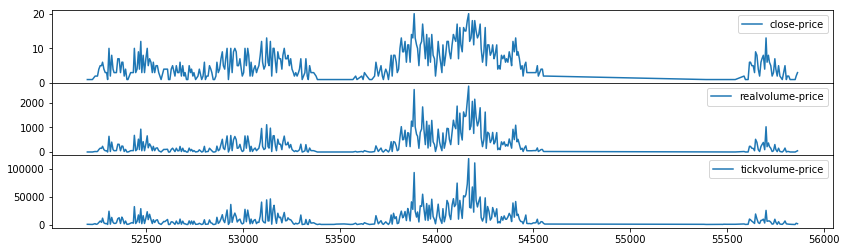

In [65]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(14,4))
ax1.plot(x[histprices.index], histprices, label='close-price')
ax1.get_xaxis().set_ticks([])
ax2.plot(x[histprices.index], rvprices, label='realvolume-price')
ax2.get_xaxis().set_ticks([])
ax3.plot(x[histprices.index], tvprices, label='tickvolume-price')
ax1.legend()
ax2.legend()
ax3.legend()
plt.subplots_adjust(hspace=0)

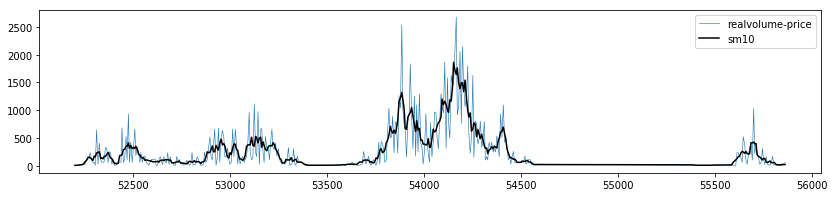

In [70]:
plt.figure(figsize=(14,3))
plt.plot(x[histprices.index], rvprices, label='realvolume-price', lw=0.6)
plt.plot(x[histprices.index], np.convolve(rvprices, np.ones(5)*1./5, mode='same'), 'k',  label='sm10')
plt.legend()

- kernel density has the advantage to be able to calculate probabilities or cdf for any price 
- 

In [57]:
np.corrcoef(tvprices, histprices)

array([[1.        , 0.90594211],
       [0.90594211, 1.        ]])

In [56]:
np.corrcoef(tvprices, rvprices)

array([[1.        , 0.96904114],
       [0.96904114, 1.        ]])

### Histogram of Prices Volumes Corrected

In [16]:
kde = kd(kernel='gaussian', bandwidth=20).fit(cprices[:, np.newaxis])
#kde = kd(kernel='exponential', bandwidth=25).fit(prices[:, np.newaxis])

In [90]:
vprices = prices.RV*prices.C

In [84]:
bin_means

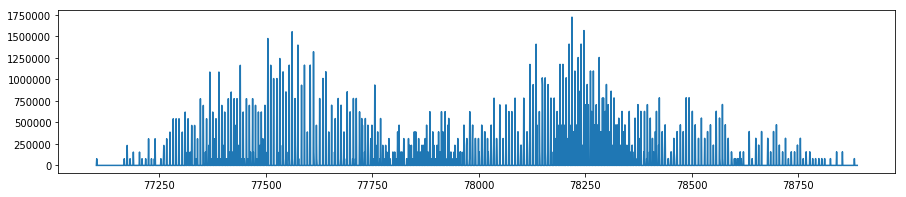

In [85]:
plt.figure(figsize=(15,3))
plt.plot(x, bin_vprice)

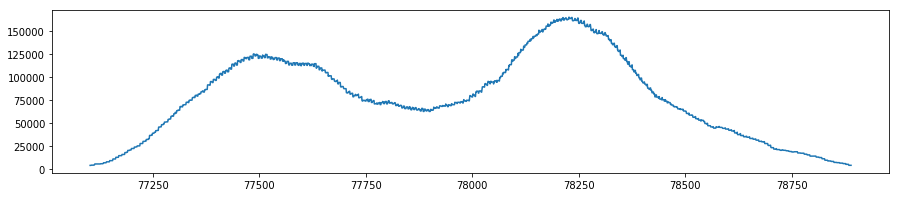

In [104]:
plt.figure(figsize=(15,3))
plt.plot(x, np.convolve(bin_sum, np.ones(300)*1./300., mode='same'))

In [65]:
density = np.exp(kde.score_samples(x[:, np.newaxis]))

In [66]:
cprices

array([77835., 77835., 77792., ..., 77979., 78001., 78015.])

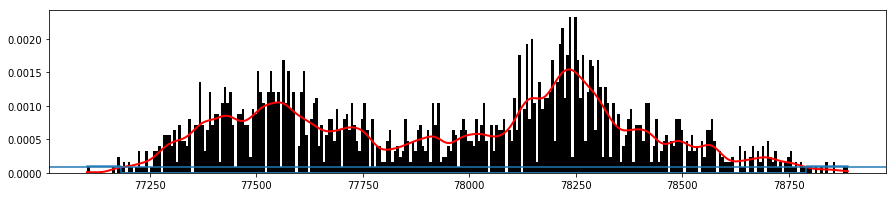

In [68]:
plt.figure(figsize=(15,3))
plt.hist(cprices, bins=300, density=True, color='k');
plt.plot(x, density, 'r', lw=2)
plt.axhline(np.percentile(density, 10)) # bellow most likely no data
nodata = np.ones(len(density))*(density < np.percentile(density, 10))
plt.plot(x, nodata*1e-4)

In [69]:
kde = kd(kernel='gaussian', bandwidth=30).fit(cprices[:, np.newaxis])
log_dens = np.exp(kde.score_samples(x[:, np.newaxis]))

In [70]:
@njit
def norm_minmax(arr):
    minv, maxv = np.min(arr), np.max(arr)
    return (arr - minv)/(maxv - minv)

In [71]:
dprobs = norm_minmax(log_dens)

In [72]:
peaks = argrelextrema(dprobs, np.greater, order=1)[0]
# just 3 higher peaks
peaks = peaks[np.argsort(dprobs[peaks])[-4:]]

#### Water-gradient style

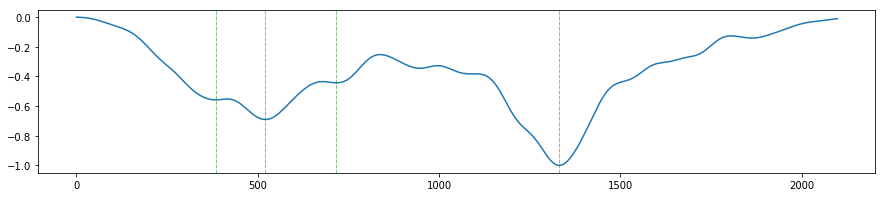

In [73]:
plt.figure(figsize=(15,3))
plt.plot(np.arange(len(dprobs)), -dprobs)
for xc in peaks.flatten():
    plt.axvline(x=xc, color='g', ls='-.', lw=0.5)